# Непараметрические критерии
# Независимые выборки

  Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

## Недвижимость в Сиэттле

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [3]:
seattle_data = pd.read_csv('seattle.txt', sep = '\t', header = 0)

In [4]:
seattle_data.shape

(100, 2)

In [5]:
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [6]:
# разделим данные по разным годам
price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price

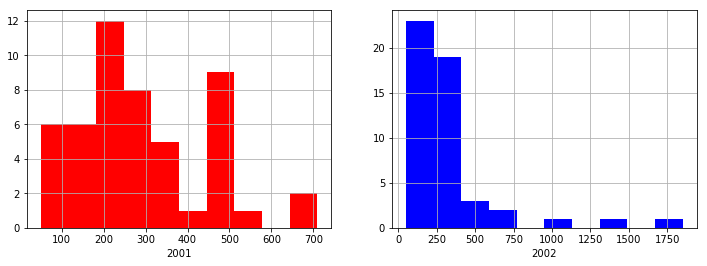

In [7]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

## Двухвыборочные критерии для независимых выборок

In [8]:
print '95%% confidence interval for the mean: [%f, %f]' % zconfint(price2001)

95% confidence interval for the mean: [245.193581, 332.659499]


In [9]:
print '95%% confidence interval for the mean: [%f, %f]' % zconfint(price2002)

95% confidence interval for the mean: [241.437946, 417.076334]


### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
stats.mannwhitneyu(price2001, price2002)

MannwhitneyuResult(statistic=1204.5, pvalue=0.37819363378508741)

Нулевая гипотеза не отвергнута, нельзя сказать что цены изменились

### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [14]:
# T-статистика это разность средних
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [15]:
# случайные комбинации в случае ограничения на количество переборов (max_combinations)
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [16]:
# определение нулевого распределения посредсвтом перебора всех возмодных комбинаций 
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None): # max_combinations - ограничения на кол. перестановок
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

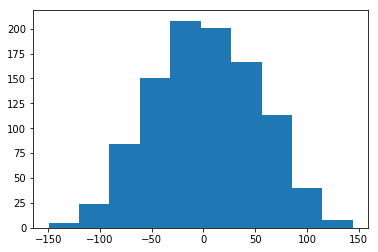

In [19]:
pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations = 1000))
pylab.show()

In [20]:
# определение критерия значимости
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    # T-статистика
    t_stat = permutation_t_stat_ind(sample, mean)
    
    # 
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [21]:
print "p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000)

p-value: 0.443500


In [22]:
print "p-value: %f" % permutation_test(price2001, price2002, max_permutations = 50000)

p-value: 0.444620


Нулевое распределение не отвергается, следовательно цены не изменились